In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from transformers import BartForConditionalGeneration, BartTokenizer
import random
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import re


C:\Users\kimia\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#Load Data

subset_size = 10000
trainFile = pd.read_csv('train.csv')
testFile = pd.read_csv('test.csv')

sampled_train = trainFile.sample(n=subset_size, random_state=40)
sampled_test = testFile.sample(n=subset_size, random_state=40)

train_articles = sampled_train['article'] 
train_summaries = sampled_train['highlights']  

test_articles =sampled_test['article']   
test_summaries = sampled_test['highlights']

In [5]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s.!?]', '', text)  # Preserve punctuation for sentence splitting
    text = re.sub(' +', ' ', text)
    return text

sampled_train['article'] = sampled_train['article'].apply(clean_text)
sampled_train['highlights'] = sampled_train['highlights'].apply(clean_text)

In [6]:
# n sentences of an article
def get_lead_by_word_count(text, word_limit=100):
    sentences = text.split('. ')
    selected_sentences = []
    current_word_count = 0
    
    for sentence in sentences:
        current_word_count += len(sentence.split())
        if current_word_count <= word_limit:
            selected_sentences.append(sentence)
        else:
            break
            
    return '. '.join(selected_sentences)

sampled_train['predicted_summary'] = sampled_train['article'].apply(get_lead_by_word_count)

for i in range(5):
    print("Original Summary:\n", sampled_train['article'].iloc[i])
    print("\n")
    print("Predicted Summary:\n", sampled_train['predicted_summary'].iloc[i])
    print("\n")


Original Summary:
 By . Damien Gayle . Dognappers who threatened to slice up a pet pug returned him after they were named and shamed them on Facebook the dogs owner claimed today. Maria Smith said crooks had demanded 2000 ransom in exchange for the safe return of Simba who was snatched from her home in Walton Liverpool. But Simba was eventually returned unharmed after Miss Smith tracked down the culprits on social media websites following a Facebook appeal. Safe Trainee beautician Maria Smith cuddles Simba her pet dog who she was only able to get back from ruthless dognappers who threatened to slice him up after Facebook detective work led her to the culprits . Merseyside Police said they were investigating the allegations. After Simba went missing the trainee beautician had taken to the Internet in a bid to track him down. People got in touch with me to say they had been offered my dog for sale and that the thieves were going around asking people if they wanted to buy a dog she said. 

In [7]:
#TF-IDF scores
def tfidf_based_summarization(text, n=5):
    sentences = text.split('. ')
    
    vectorizer = TfidfVectorizer().fit(sentences)
    tfidf_matrix = vectorizer.transform(sentences)
    sentence_scores = np.sum(tfidf_matrix.toarray(), axis=1)
    
    ranked_sentences = [sentences[i] for i in np.argsort(sentence_scores, axis=0)[-n:]]
    return '. '.join(ranked_sentences)

sampled_train['predicted_summary'] = sampled_train['article'].apply(tfidf_based_summarization)

for i in range(5):
    print("Original Summary:\n", sampled_train['article'].iloc[i])
    print("\n")
    print("Predicted Summary:\n", sampled_train['predicted_summary'].iloc[i])
    print("\n")


Original Summary:
 By . Damien Gayle . Dognappers who threatened to slice up a pet pug returned him after they were named and shamed them on Facebook the dogs owner claimed today. Maria Smith said crooks had demanded 2000 ransom in exchange for the safe return of Simba who was snatched from her home in Walton Liverpool. But Simba was eventually returned unharmed after Miss Smith tracked down the culprits on social media websites following a Facebook appeal. Safe Trainee beautician Maria Smith cuddles Simba her pet dog who she was only able to get back from ruthless dognappers who threatened to slice him up after Facebook detective work led her to the culprits . Merseyside Police said they were investigating the allegations. After Simba went missing the trainee beautician had taken to the Internet in a bid to track him down. People got in touch with me to say they had been offered my dog for sale and that the thieves were going around asking people if they wanted to buy a dog she said. 

In [8]:
from collections import Counter

def rouge_1_score(summary, reference):
    """Calculate ROUGE-1 (unigram overlap) score between summary and reference."""
    summary_unigrams = Counter(summary.split())
    reference_unigrams = Counter(reference.split())
    
    # Find the number of unigram overlaps
    overlap = sum(min(count, reference_unigrams[word]) for word, count in summary_unigrams.items())
    
    # Calculate precision, recall, and F1
    precision = overlap / sum(summary_unigrams.values())
    recall = overlap / sum(reference_unigrams.values())
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    
    return f1_score

# Assuming sampled_train['reference_summary'] contains the gold standard summaries
sampled_train['rouge_1_score'] = sampled_train.apply(lambda row: rouge_1_score(row['predicted_summary'], row['highlights']), axis=1)

# Calculate the average ROUGE-1 score across all summaries
average_rouge_1 = sampled_train['rouge_1_score'].mean()
print("Average ROUGE-1 Score:", average_rouge_1)


Average ROUGE-1 Score: 0.22898465081526573


In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

# Pre-fit the TF-IDF vectorizer on all sentences
all_sentences = [sentence for article in sampled_train['article'] for sentence in article.split('. ')]
vectorizer = TfidfVectorizer().fit(all_sentences)

def apply_clustering(tfidf_matrix, num_clusters=5):
    # Use MiniBatchKMeans for faster processing
    km = MiniBatchKMeans(n_clusters=num_clusters, batch_size=1000, n_init=10)
    km.fit(tfidf_matrix)
    clusters = km.labels_
    return clusters

def tfidf_based_summarization_with_clustering(text, n=5):
    sentences = text.split('. ')
    num_clusters = min(n, len(sentences)) if len(sentences) > 1 else 1
    tfidf_matrix = vectorizer.transform(sentences)
    
    if num_clusters > 1:
        sentence_clusters = apply_clustering(tfidf_matrix, num_clusters=num_clusters)
        clustered_sentences = []
        for cluster_num in range(num_clusters):
            cluster_indices = np.where(sentence_clusters == cluster_num)[0]
            if cluster_indices.size == 0:
                continue
            cluster_scores = tfidf_matrix[cluster_indices].sum(axis=1).A1
            highest_score_index = cluster_indices[np.argmax(cluster_scores)]
            clustered_sentences.append(sentences[highest_score_index])
        return '. '.join(clustered_sentences)
    else:
        return text if sentences else ''

# Process the data
clustered_summaries = [tfidf_based_summarization_with_clustering(article, n=5) for article in sampled_train['article']]
sampled_train['clustered_summary'] = clustered_summaries

# Display the results for the first few articles
for i in range(5):
    print("Original Summary:\n", sampled_train['article'].iloc[i])
    print("\n")
    print("Clustered Summary:\n", sampled_train['clustered_summary'].iloc[i])
    print("\n")


KeyboardInterrupt: 

In [2]:
from rouge import Rouge

# Calculate ROUGE scores
def calculate_rouge_scores(clustered_summaries, reference_summaries):
    rouge = Rouge()
    scores = [rouge.get_scores(cs, rs) for cs, rs in zip(clustered_summaries, reference_summaries)]
    return scores

rouge_scores = calculate_rouge_scores(sampled_train['clustered_summary'], sampled_train['highlights'])
print(rouge_scores[:5])


NameError: name 'sampled_train' is not defined

In [9]:
from transformers import BartForConditionalGeneration, BartTokenizer

model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the last layer
for param in model.model.decoder.layers[-1].parameters():
    param.requires_grad = True

inputs = tokenizer(["article"], return_tensors="pt", max_length=512, truncation=True, padding="max_length")
labels = tokenizer(["predicted_summary"], return_tensors="pt", max_length=128, truncation=True, padding="max_length")

from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(inputs.input_ids, labels.input_ids)
data_loader = DataLoader(dataset, batch_size=8)

from torch.optim import AdamW

# optimize the parameters (unfrozen)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()))

model.train()
num_epochs = 20
for epoch in range(num_epochs):
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch[0]
        labels = batch[1]
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch}, Loss: {loss.item()}")


Epoch: 0, Loss: 12.004195213317871
Epoch: 1, Loss: 10.411303520202637
Epoch: 2, Loss: 8.286102294921875
Epoch: 3, Loss: 6.476675510406494
Epoch: 4, Loss: 4.84382963180542
Epoch: 5, Loss: 3.753561496734619
Epoch: 6, Loss: 2.705806255340576
Epoch: 7, Loss: 2.205522298812866
Epoch: 8, Loss: 2.0613620281219482
Epoch: 9, Loss: 2.1726572513580322
Epoch: 10, Loss: 2.1258227825164795
Epoch: 11, Loss: 1.9885722398757935
Epoch: 12, Loss: 1.6757968664169312
Epoch: 13, Loss: 1.6641385555267334
Epoch: 14, Loss: 1.6425862312316895
Epoch: 15, Loss: 1.3996113538742065
Epoch: 16, Loss: 1.413618803024292
Epoch: 17, Loss: 1.322404384613037
Epoch: 18, Loss: 1.3391271829605103
Epoch: 19, Loss: 1.3287562131881714


In [12]:
sampled_train.reset_index(drop=True, inplace=True)
sampled_test.reset_index(drop=True, inplace=True)

from torch.utils.data import Dataset

class TextSummarizationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_input_length=512, max_output_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        article = self.dataframe.iloc[idx]['article']
        summary = self.dataframe.iloc[idx]['highlights']
        inputs = self.tokenizer(article, return_tensors="pt", max_length=self.max_input_length, truncation=True, padding="max_length")
        outputs = self.tokenizer(summary, return_tensors="pt", max_length=self.max_output_length, truncation=True, padding="max_length")
        return inputs.input_ids.squeeze(0), outputs.input_ids.squeeze(0)

train_dataset = TextSummarizationDataset(sampled_train, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
model.train()
num_epochs = 3

for epoch in range(num_epochs):
    for batch_idx, (input_ids, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}")



Epoch: 0, Batch: 0, Loss: 6.570940017700195
Epoch: 0, Batch: 1, Loss: 5.074437618255615
Epoch: 0, Batch: 2, Loss: 4.437767028808594
Epoch: 0, Batch: 3, Loss: 4.039012432098389
Epoch: 0, Batch: 4, Loss: 3.5579638481140137


KeyboardInterrupt: 

In [10]:
#Costumized dataset for better standardization and flexibility
from torch.utils.data import Dataset
from torch import tensor

class CNNDailyMailDataset(Dataset):
    def __init__(self, articles, summaries, tokenizer, max_length=512):
        self.articles = articles
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.articles)

    def __getitem__(self, idx):
        article = self.articles[idx]
        summary = self.summaries[idx]
        if idx >= len(self.articles):
            raise IndexError(f"Index {idx} out of range")

        # Tokenize the article and summary
        input_ids = self.tokenizer.encode(article, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt").squeeze()
        label_ids = self.tokenizer.encode(summary, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt").squeeze()

        return input_ids, label_ids


train_articles.reset_index(drop=True, inplace=True)
train_summaries.reset_index(drop=True, inplace=True)
test_articles.reset_index(drop=True, inplace=True)
test_summaries.reset_index(drop=True, inplace=True)

# Then create the datasets
train_dataset = CNNDailyMailDataset(train_articles, train_summaries, tokenizer)
test_dataset = CNNDailyMailDataset(test_articles, test_summaries, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

for i, batch in enumerate(train_loader):
    if i == 1020:
        print(f"Batch at index 1020: {batch}")
        break


print(f"Epoch: {epoch}, Loss: {loss.item()}")



Batch at index 1020: [tensor([[    0, 24375, 10909,  ...,   784,   571,     2],
        [    0,  1640, 16256,  ...,     1,     1,     1],
        [    0,   243,    18,  ...,     5,  9288,     2],
        ...,
        [    0,  3762,   766,  ...,     1,     1,     1],
        [    0,   250, 15860,  ...,   128, 17357,     2],
        [    0,  1640, 16256,  ...,  5412, 18092,     2]]), tensor([[    0, 24375, 10909,  ...,     1,     1,     1],
        [    0, 20861,  3281,  ...,     1,     1,     1],
        [    0, 20439, 11560,  ...,     1,     1,     1],
        ...,
        [    0,   863, 17773,  ...,     1,     1,     1],
        [    0, 17357,   108,  ...,     1,     1,     1],
        [    0, 45784,    35,  ...,     1,     1,     1]])]
Epoch: 19, Loss: 1.3287562131881714


In [11]:
from transformers import BartForConditionalGeneration

model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the last layer in the decoder
for param in model.model.decoder.layers[-1].parameters():
    param.requires_grad = True


In [15]:
#for 1020 error, this code helped me to get the better idea of where the error might come from.
print(len(train_articles), len(train_summaries))
train_articles.reset_index(drop=True, inplace=True)
train_summaries.reset_index(drop=True, inplace=True)
for i, batch in enumerate(train_loader):
    try:
        input_ids, labels = batch
    except KeyError as e:
        print(f"Error at batch index: {i}")
        raise e



10000 10000


In [9]:
model.train()
model.eval()  

test_article = sampled_test['article'].iloc[0]
inputs = tokenizer([test_article], return_tensors="pt", max_length=512, truncation=True, padding="max_length")
summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(generated_summary)

for i in range(5):
    test_article = sampled_test['article'].iloc[i]
    inputs = tokenizer([test_article], return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    print(f"Article {i+1} Summary:")
    print(generated_summary)
    print("\n")


The 41-year-old mother-of-two has battled back from injury to take part in the 26.2 mile race in the capital. She said this week: 'I'm going in unfit and unprepared for a marathon, but I'm hoping my body can remember once it gets out there how it's supposed to do it' Paula will be presented with the inaugural John Disley Lifetime Achievement award in honour of her achievements.
Article 1 Summary:
The 41-year-old mother-of-two has battled back from injury to take part in the 26.2 mile race in the capital. She said this week: 'I'm going in unfit and unprepared for a marathon, but I'm hoping my body can remember once it gets out there how it's supposed to do it' Paula will be presented with the inaugural John Disley Lifetime Achievement award in honour of her achievements.


Article 2 Summary:
Philippe Coutinho is becoming Liverpool's go-to guy, according to Jamie Carragher. Coutinho starred for Liverpool in their 2-0 win against Newcastle United on Monday night. Liverpool sold star strik

In [10]:
#Rouge Test
reference_summaries = [sampled_test['highlights'].iloc[i] for i in range(5)]
generated_summaries = []
for i in range(5):
    test_article = sampled_test['article'].iloc[i]
    inputs = tokenizer([test_article], return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    generated_summaries.append(generated_summary)
from rouge import Rouge 

rouge = Rouge()

rouge_scores = rouge.get_scores(generated_summaries, reference_summaries, avg=True)

print("Rouge Scores:", rouge_scores)




Rouge Scores: {'rouge-1': {'r': 0.4200915032679739, 'p': 0.43524261927962116, 'f': 0.41843497412610464}, 'rouge-2': {'r': 0.1577885411202425, 'p': 0.1801897684216613, 'f': 0.16296273877022555}, 'rouge-l': {'r': 0.4053202614379085, 'p': 0.41702630049404243, 'f': 0.40215454569377745}}


In [11]:
# Extract F1-scores, Precision, and Recall for each ROUGE type
rouge_f1_scores = [rouge_scores['rouge-1']['f'], rouge_scores['rouge-2']['f'], rouge_scores['rouge-l']['f']]
rouge_precision_scores = [rouge_scores['rouge-1']['p'], rouge_scores['rouge-2']['p'], rouge_scores['rouge-l']['p']]
rouge_recall_scores = [rouge_scores['rouge-1']['r'], rouge_scores['rouge-2']['r'], rouge_scores['rouge-l']['r']]

rouge_types = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

print(rouge_types)
print(rouge_f1_scores)
print(rouge_precision_scores)
print(rouge_recall_scores)


['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
[0.41843497412610464, 0.16296273877022555, 0.40215454569377745]
[0.43524261927962116, 0.1801897684216613, 0.41702630049404243]
[0.4200915032679739, 0.1577885411202425, 0.4053202614379085]


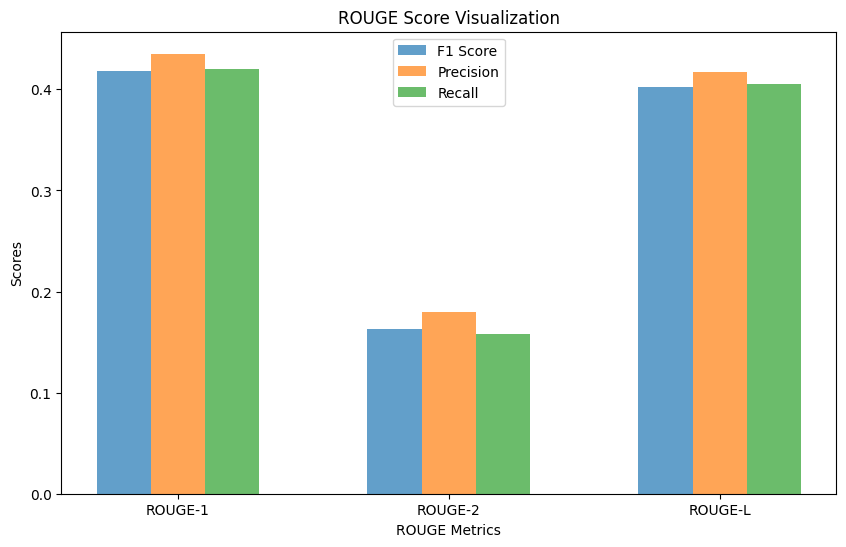

In [26]:
import matplotlib.pyplot as plt

# Set the positions and width for the bars
positions = range(len(rouge_types))
width = 0.2

# Plotting
plt.figure(figsize=(10, 6))
plt.bar([p - width for p in positions], rouge_f1_scores, width, alpha=0.7, label='F1 Score')
plt.bar(positions, rouge_precision_scores, width, alpha=0.7, label='Precision')
plt.bar([p + width for p in positions], rouge_recall_scores, width, alpha=0.7, label='Recall')

plt.xlabel('ROUGE Metrics')
plt.ylabel('Scores')
plt.title('ROUGE Score Visualization')
plt.xticks(positions, rouge_types)
plt.legend()
plt.show()


In [55]:
def get_ngrams(text, n=2):
    # Tokenize the text into words
    words = text.split()
    # Create n-grams
    n_grams = zip(*[words[i:] for i in range(n)])
    return [' '.join(n_gram) for n_gram in n_grams]

generated_ngrams = get_ngrams(generated_summary, n=1)
reference_ngrams = get_ngrams(reference_summary, n=1)
def overlap_matrix(generated_ngrams, reference_ngrams):
    matrix = np.zeros((len(generated_ngrams), len(reference_ngrams)))
    for i, g_ngram in enumerate(generated_ngrams):
        for j, r_ngram in enumerate(reference_ngrams):
            matrix[i][j] = 1 if g_ngram == r_ngram else 0
    return matrix

overlap_matrix = overlap_matrix(generated_ngrams, reference_ngrams)


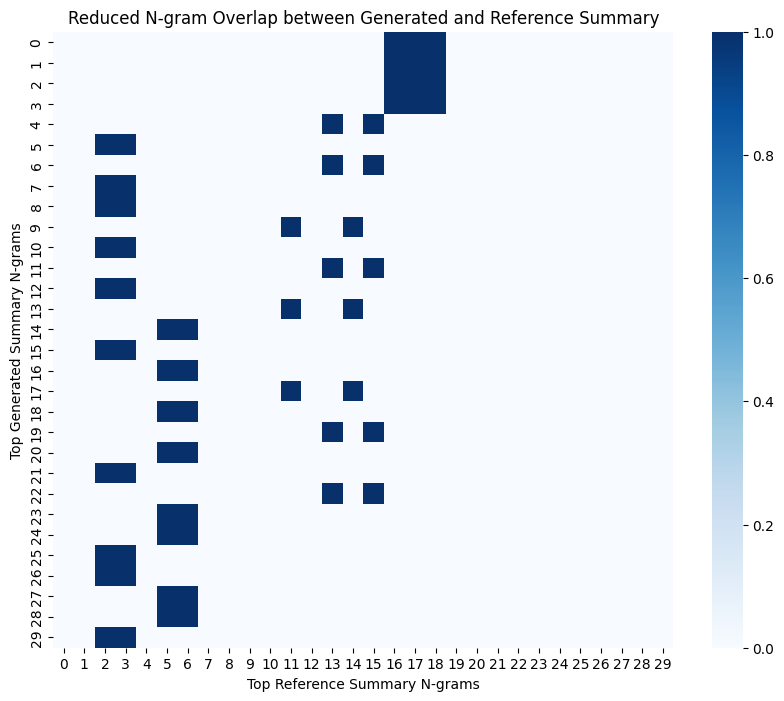

In [56]:
# Assuming 'overlap_matrix' is already computed and is a large matrix
# Limit the number of n-grams to the top N most frequent

# Define the number of n-grams to display
top_n = 30

# Find the top n most frequent n-grams in each summary
generated_top_ngrams = np.argsort(-np.sum(overlap_matrix, axis=1))[:top_n]
reference_top_ngrams = np.argsort(-np.sum(overlap_matrix, axis=0))[:top_n]

# Create a reduced overlap matrix
reduced_matrix = overlap_matrix[generated_top_ngrams, :][:, reference_top_ngrams]

# Plot the reduced heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(reduced_matrix, annot=False, cmap='Blues')
plt.title("Reduced N-gram Overlap between Generated and Reference Summary")
plt.xlabel("Top Reference Summary N-grams")
plt.ylabel("Top Generated Summary N-grams")
plt.show()


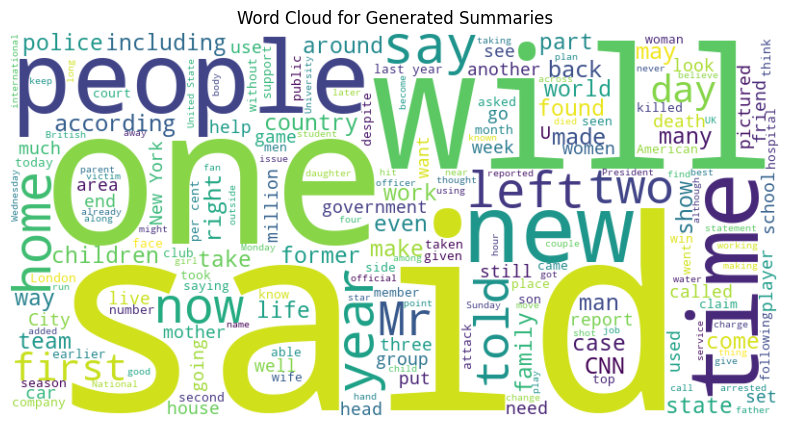

In [57]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all the generated summaries into one big text
all_generated_summaries = ' '.join(sampled_train['predicted_summary'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_generated_summaries)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Generated Summaries')
plt.show()


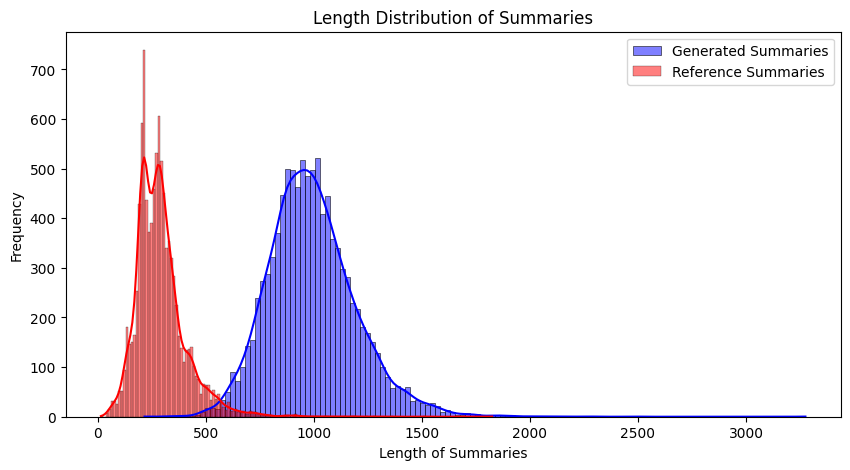

In [58]:
import seaborn as sns

# Calculate the length of each summary
generated_lengths = sampled_train['predicted_summary'].apply(len)
reference_lengths = sampled_train['highlights'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(generated_lengths, color='blue', label='Generated Summaries', kde=True)
sns.histplot(reference_lengths, color='red', label='Reference Summaries', kde=True)
plt.legend()
plt.title('Length Distribution of Summaries')
plt.xlabel('Length of Summaries')
plt.ylabel('Frequency')
plt.show()


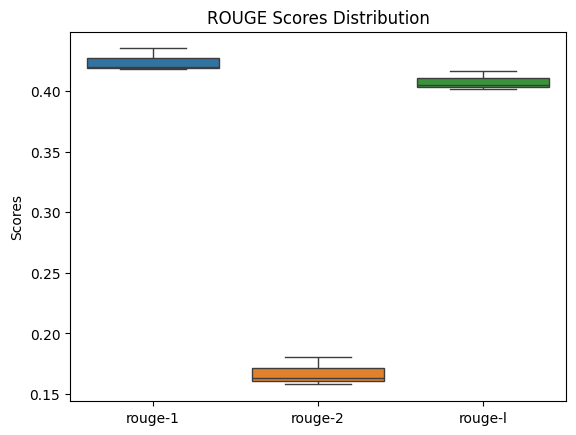

In [59]:
import pandas as pd

# Sample DataFrame with ROUGE scores

# Extract F1-scores, Precision, and Recall for each ROUGE type
rouge_f1_scores = [rouge_scores['rouge-1']['f'], rouge_scores['rouge-2']['f'], rouge_scores['rouge-l']['f']]
rouge_precision_scores = [rouge_scores['rouge-1']['p'], rouge_scores['rouge-2']['p'], rouge_scores['rouge-l']['p']]
rouge_recall_scores = [rouge_scores['rouge-1']['r'], rouge_scores['rouge-2']['r'], rouge_scores['rouge-l']['r']]

rouge_types = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']


rouge_scores_df = pd.DataFrame({
    'rouge-1': [ 0.4200915032679739,  0.43524261927962116, 0.41843497412610464],  # Replace with actual scores
    'rouge-2': [0.1577885411202425, 0.1801897684216613, 0.16296273877022555],
    'rouge-l': [0.4053202614379085,0.41702630049404243,0.40215454569377745]
})

sns.boxplot(data=rouge_scores_df)
plt.title('ROUGE Scores Distribution')
plt.ylabel('Scores')
plt.show()


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Assuming 'articles' is a list of all news articles in your dataset
# For example: articles = [article1_text, article2_text, ...]

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_articles)
cumulative_features = []
feature_count = 0
for i in range(X.shape[0]):
    feature_count = len(vectorizer.get_feature_names_out()[:i+1])
    cumulative_features.append(feature_count)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_features, label='Cumulative Features')
plt.xlabel('Number of Articles')
plt.ylabel('Cumulative Number of Features')
plt.title('Number of Features vs Total Number of Data Points')
plt.legend()
plt.show()


KeyboardInterrupt: 

In [15]:
from transformers import BartForConditionalGeneration, BartTokenizer, AdamW
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# Load the tokenizer and model
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

# Set up the data loaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=4)

# Define the optimizer
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)


# Training loop
model.train()
num_epochs = 3
for epoch in range(num_epochs):
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):
        optimizer.zero_grad()

        # Adjust based on the actual structure of your batch
        input_ids, labels = batch

        # Assuming the attention mask is not provided and needs to be created
        attention_mask = torch.ones_like(input_ids).to(input_ids.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss = outputs.loss

# Save the fine-tuned model
model.save_pretrained('./fine_tuned_model')
tokenizer.save_pretrained('./fine_tuned_model')

# Evaluate with ROUGE after generating summaries on validation data
# ... [Code to generate summaries and calculate ROUGE scores] ...


Training Epoch 0:   0%|                                                          | 4/2500 [10:42<111:20:42, 160.59s/it]


KeyboardInterrupt: 

In [19]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def clean_summary(summary):
    sentences = sent_tokenize(summary)
    return ' '.join(sentences)

# Initialize the grammar checker

def post_process(summary):
    # Grammar and punctuation correction
    corrected_summary = tool.correct(summary)

    # Split into sentences
    sentences = sent_tokenize(corrected_summary)

    # Remove any repeated sentences
    unique_sentences = []
    seen = set()
    for sentence in sentences:
        if sentence not in seen:
            unique_sentences.append(sentence)
            seen.add(sentence)

    # Reassemble the summary
    return ' '.join(unique_sentences)

for i in range(5):
    test_article = sampled_test['article'].iloc[i]
    inputs = tokenizer([test_article], return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    print(f"Article {i+1} Summary:")
    print(generated_summary)
    print("\n")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kimia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kimia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Article 1 Summary:
The 41-year-old mother-of-two has battled back from injury to take part in the 26.2 mile race. She will run with the masses and says she's going in 'unfit and unprepared for a marathon' She has won the London Marathon three times, including in 2003 when she set a new world record time of 2 hours 15 minutes and 25 seconds. Paula will be presented with the inaugural John Disley Lifetime Achievement award.


Article 2 Summary:
Liverpool beat Newcastle United 2-0 in the Premier League on Monday night. Liverpool sold Luis Suarez to Barcelona for £75million during the summer. Philippe Coutinho is becoming Liverpool's go-to guy, according to Jamie Carragher.


Article 3 Summary:
Lewis Hamilton takes pole for the Bahrain Grand Prix by four tenths of a second from Ferrari's Sebastian Vettel. Hamilton's Mercedes team-mate Nico Rosberg was third in qualifying. Jenson Button's McLaren broke down during qualifying and he will start 20th and last.


Article 4 Summary:
Raheem Sterl

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration
from rouge_score import rouge_scorer
import torch

# Load model and tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
model.to('cpu')  # Run on CPU

# Function to generate summaries for a batch of articles
def generate_summaries(articles):
    summaries = []
    for article in articles:
        inputs = tokenizer([article], return_tensors="pt", max_length=512, truncation=True, padding="max_length").to('cpu')
        summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
        generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(generated_summary)
    return summaries

# Generate summaries in batches
batch_size = 10  # Adjust based on your GPU's memory
generated_summaries = []
for i in range(0, len(sampled_test), batch_size):
    batch_articles = sampled_test['article'].iloc[i:i + batch_size].tolist()
    batch_summaries = generate_summaries(batch_articles)
    generated_summaries.extend(batch_summaries)

# Post-process your generated summaries
post_processed_summaries = [post_process(clean_summary(summary)) for summary in generated_summaries]

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
rouge_scores = [scorer.score(ref_summary, gen_summary) for ref_summary, gen_summary in zip(reference_summaries, post_processed_summaries)]

# Compute the average ROUGE scores
avg_rouge_scores = {key: np.mean([score[key].fmeasure for score in rouge_scores]) for key in rouge_scores[0]}

print("Average ROUGE scores after post-processing:", avg_rouge_scores)